# Kaggle Titanic Competition
#### Date: 2021-08-27
#### Author: Isaac Lee

## Imports

In [82]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

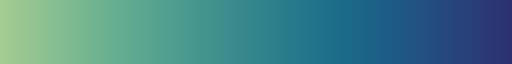

In [83]:
sns.set() # Setting seaborn as default style
sns.set_context("talk")
sns.set(rc={'figure.figsize':(15,10)})
palette = 'crest'
sns.set_palette(palette)
cont_col = ['#1D2562', '#6CB190'] # when we need two contrasting colours
sns.color_palette(palette, as_cmap=True)

In [84]:
train_df = pd.read_csv("train.csv")
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Questions
Null values?  
How does each feature relate to survival chances?  
    - Is there a correlation between Pclass and survived?  
    - Is there a correlation between Sex, Age  
    - Are people that travelled alone more likely to die?  
    - Possible Feature engineering: Name, Ticket and Cabin  
    - Does the location of embarking effect survival rate?  
    - Are people with non-null cabins more likely to survive?

## Null Values

In [85]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

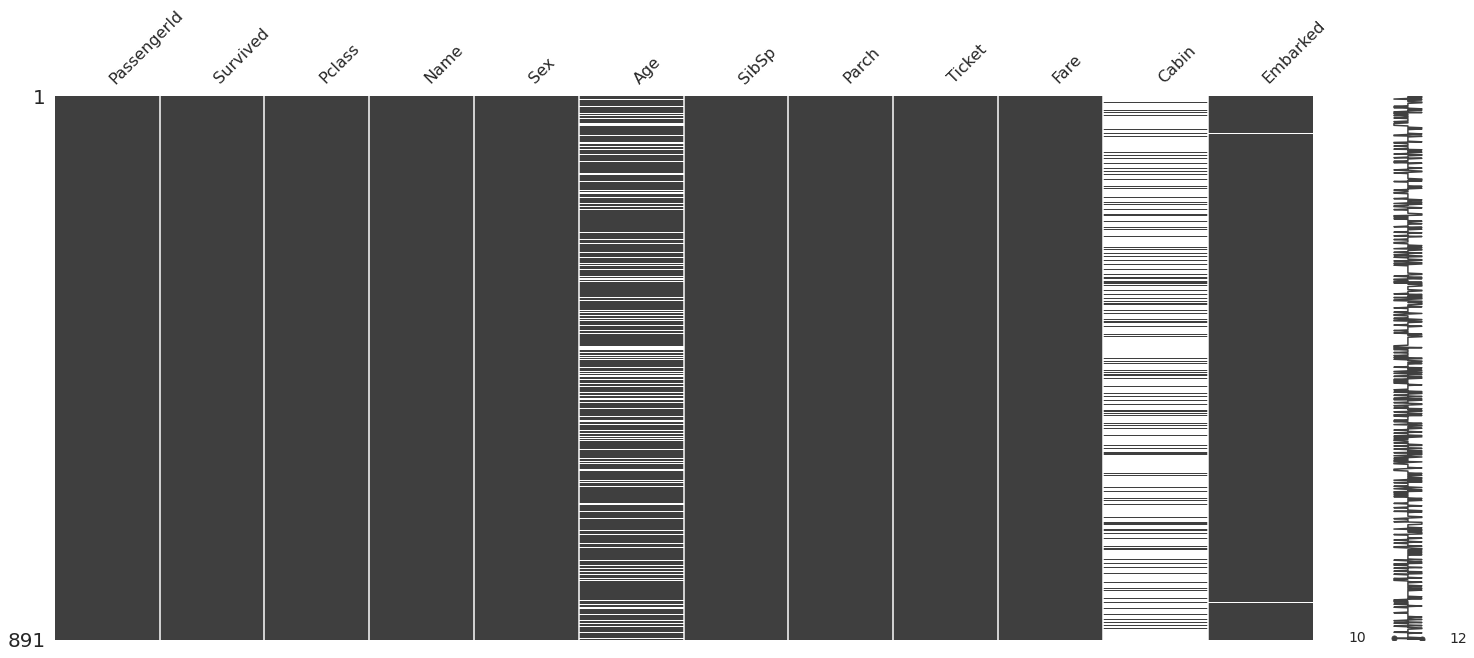

In [86]:
msno.matrix(train_df)

What percentage of people with non-null cabins survived, compared to the percentage of people with null cabins who survived?

In [87]:
died_cabins = train_df["Cabin"][train_df["Survived"] == 0] # Cabins that didn't survive
died_cabins.isnull().sum() / len(died_cabins)

0.8761384335154827

So around 87% of people who died had null values for their cabins

In [88]:
survived_cabins = train_df["Cabin"][train_df["Survived"] == 1] # Cabins that survived
survived_cabins.isnull().sum() / len(survived_cabins)

0.6023391812865497

So around 60% of people that survived had null cabins, which is lower than the amount that didn't survive suggesting a correlation, but 60% is still probably too high to be useful to us. We'll just drop this column
from the df. We also need to examine age, the only other feature with null values...

In [89]:
train_df = pd.read_csv("train.csv")
train_df.drop("Cabin", inplace=True, axis=1)

In [90]:
train_df["Age"].isnull().sum() / len(train_df["Age"])

0.19865319865319866

This is too high a percentage for us to just drop the rows with no age, so we'll have to impute the data.

/home/isaac/.virtualenvs/ml_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

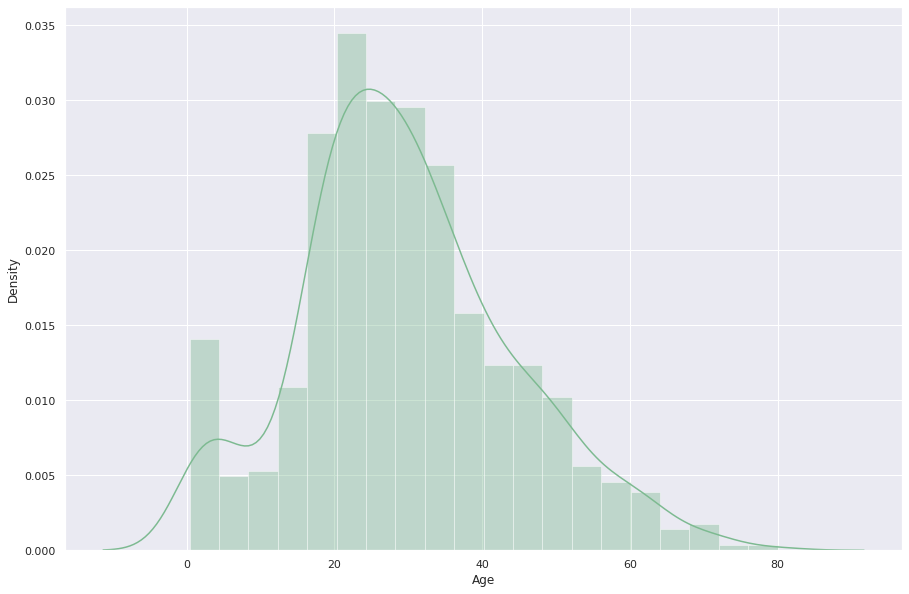

In [91]:
sns.distplot(train_df["Age"])

Data is not too skewed so we use the mean.

In [92]:
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].mean())

Finally for embarked we only have 2 missing values, so we will just drop those rows.

In [93]:
train_df["Embarked"].isnull().sum()

2

In [94]:
train_df = train_df.dropna(how='any', subset=['Embarked'])

In [95]:
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

So now we no longer have null values!

## Feature Exploration

### Numerical Features

#### Pclass

<AxesSubplot:xlabel='Pclass', ylabel='count'>

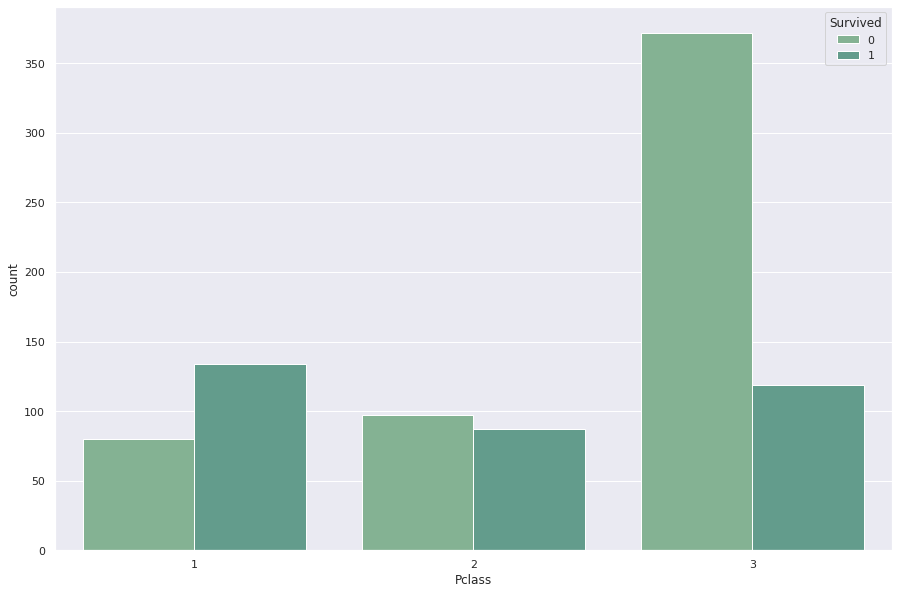

In [96]:
sns.countplot(data=train_df, x=train_df['Pclass'], hue=train_df['Survived'])

In [97]:
pd.pivot_table(train_df[['Survived', 'Pclass']], index='Pclass', aggfunc='mean')

,Survived
Pclass,
1,0.626168
2,0.472826
3,0.242363


So clearly only around a quarter of 3rd class passengers survived whereas around 60% of 1st class survived.
We can see that class is a good indicator for survival.

#### Age

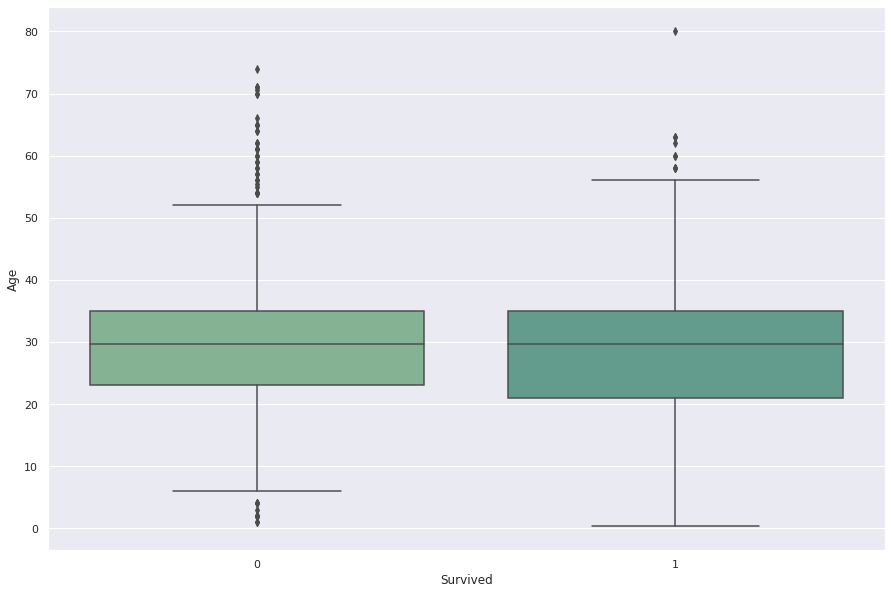

In [98]:
g = sns.boxplot(x=train_df['Survived'], y=train_df['Age'])

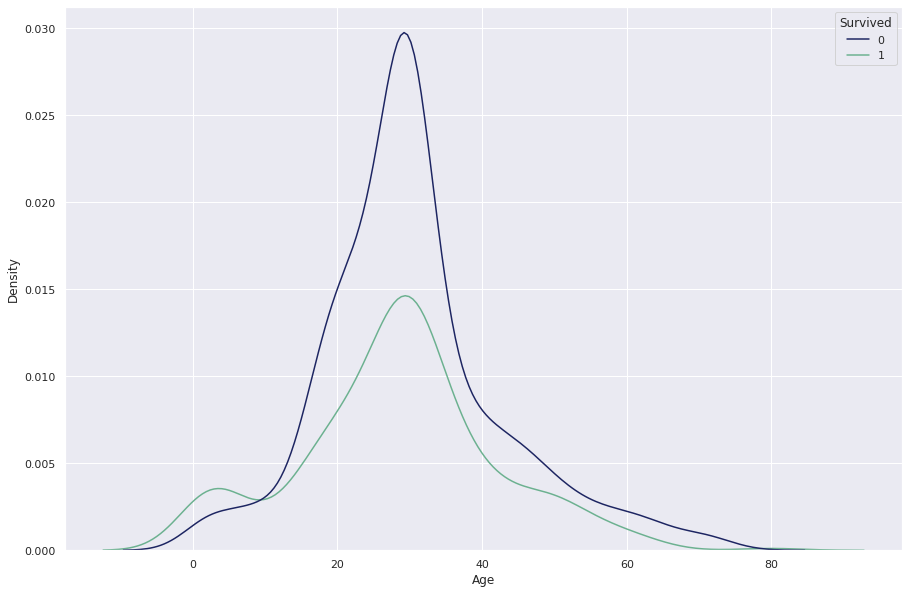

In [99]:
g = sns.kdeplot(data=train_df, x='Age', hue='Survived',palette=cont_col)

It seems like children under 10 have a higher chance of survival, whereas people in the 20-40 years range seem to have the worst chances of survival.

#### SibSP

In [100]:
train_df['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

<AxesSubplot:xlabel='SibSp', ylabel='count'>

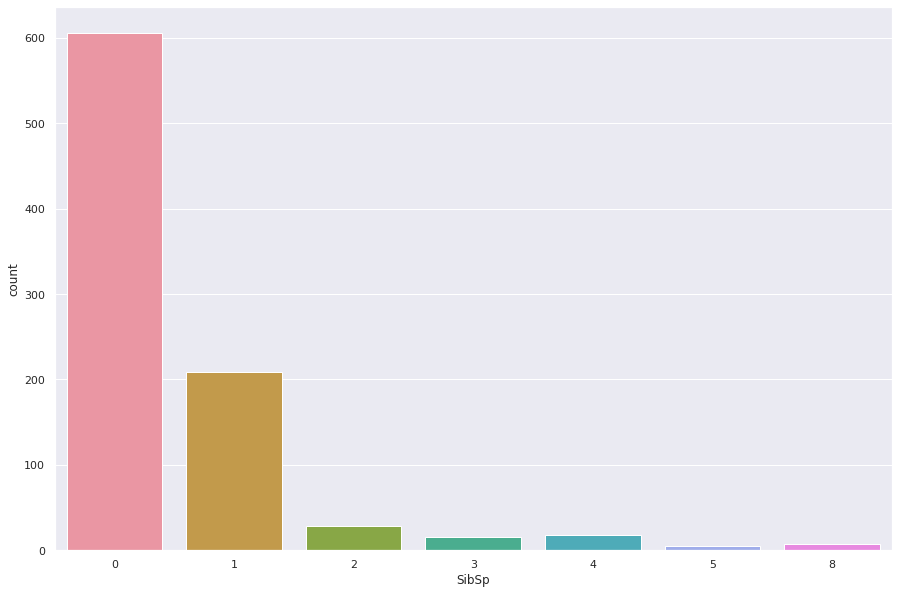

In [101]:
sns.countplot(x=train_df['SibSp'])

Question: do people with > 1 SibSp have a lower chance of surviving?

In [102]:
pd.pivot_table(train_df[['Survived', 'SibSp']], index='SibSp', aggfunc='mean')

,Survived
SibSp,
0,0.343234
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


So clearly, as the number of siblings you have increases, your change of survival decreases,
so if someone has 8 siblings, it is highly likely that they didn't survive. Interestingly
people with 1 SibSp, seem to have the highest chance of survival. In most cases these will be Spouses and I would guess that rich people would tend to have a spouse with them.

#### Parch

In [103]:
pd.pivot_table(train_df[['Survived', 'Parch']], index='Parch', aggfunc='mean')

,Survived
Parch,
0,0.341716
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


#### Fare
I would guess that people who pay a higher fare are more likely to survive.

[(0.0, 300.0)]

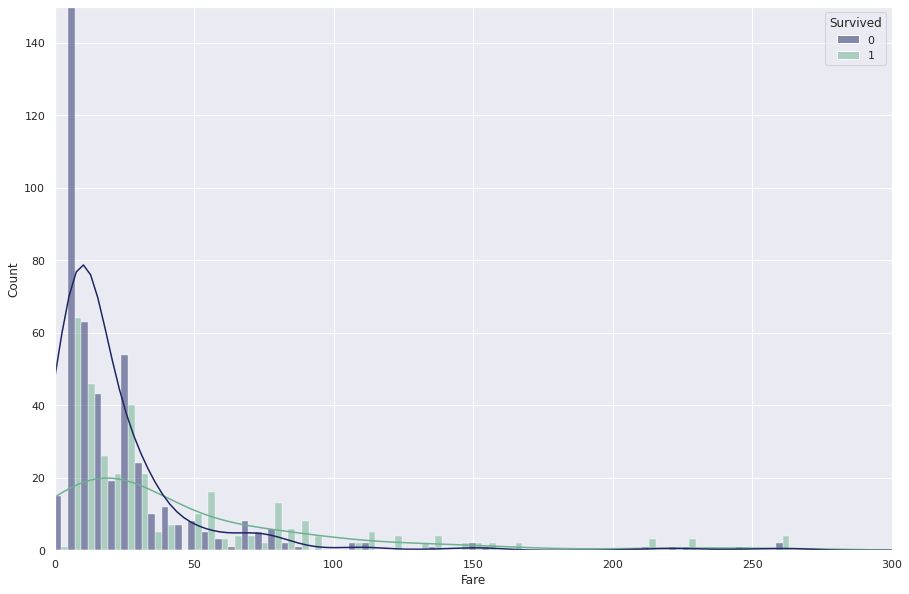

In [104]:
g = sns.histplot(data=train_df, x='Fare', hue='Survived', palette=cont_col, multiple='dodge', kde=True)
g.set(ylim=(0, 150))
g.set(xlim=(0, 300))

To make things easier, we wil separate fare into 5 bins:

In [105]:
train_df['Fare_Binned'] = pd.qcut(train_df['Fare'], 10)

In [106]:
train_df['Fare_Binned'].unique()

[(-0.001, 7.55], (39.688, 77.288], (7.854, 8.05], (8.05, 10.5], (14.454, 21.075], (10.5, 14.454], (26.82, 39.688], (21.075, 26.82], (7.55, 7.854], (77.288, 512.329]]
Categories (10, interval[float64, right]): [(-0.001, 7.55] < (7.55, 7.854] < (7.854, 8.05] < (8.05, 10.5] ... (21.075, 26.82] < (26.82, 39.688] < (39.688, 77.288] < (77.288, 512.329]]

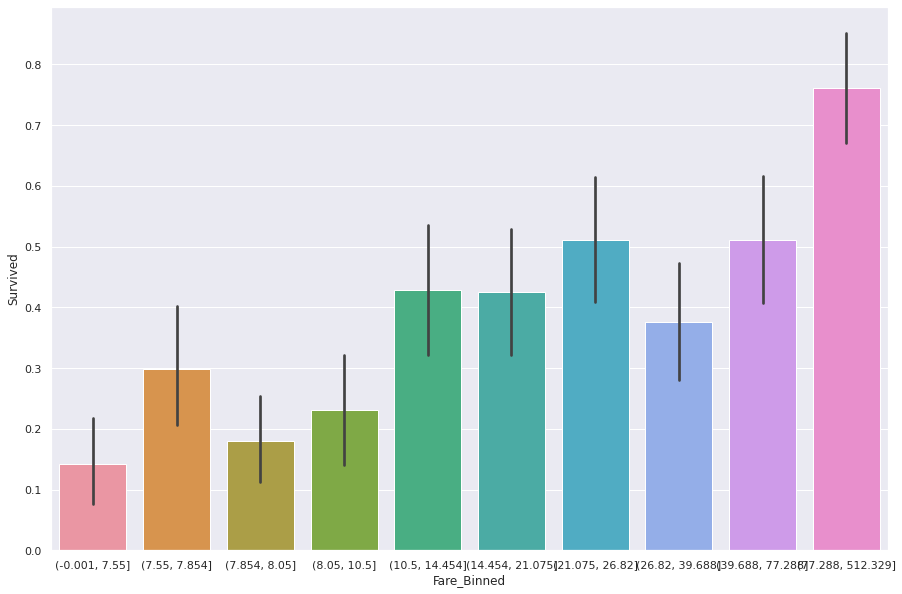

In [107]:
g = sns.barplot(data=train_df, x='Fare_Binned', y='Survived')

Clearly higher fares correlate with higher survival rates.

### Categorical Features

#### Name

In [108]:
train_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 889, dtype: object

Question: do people with longer names have a higher chance of survival?

In [109]:
train_df['Name_Len'] = train_df.apply(lambda row : len(row['Name']), axis = 1)

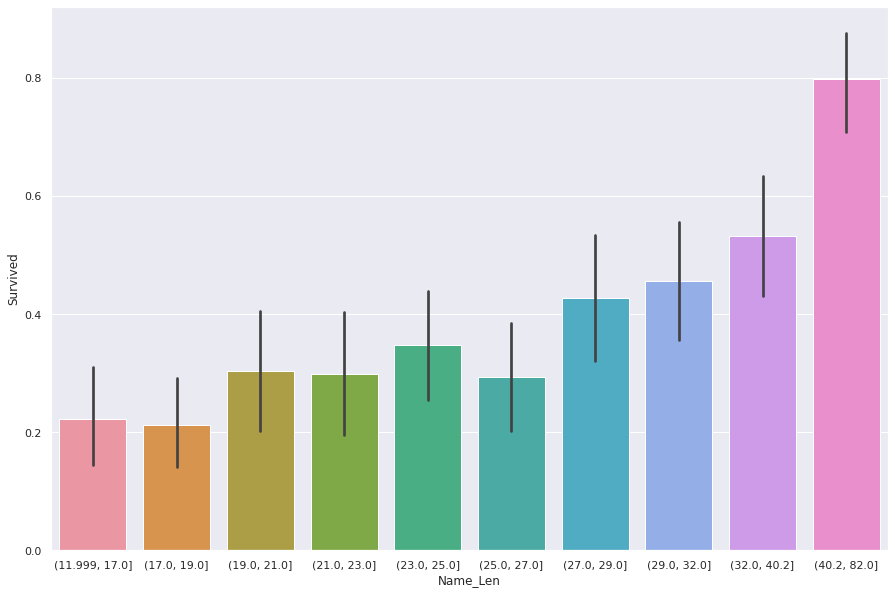

In [110]:
g = sns.barplot(data=train_df, x=pd.qcut(train_df['Name_Len'], 10), y='Survived')


So interestingly it seems that the people with longer names have a higher chance of survival.

#### Sex

I imagine sex will have a large part to play since the men were expected to let the women and children
on to the lifeboats first.

In [111]:
pd.pivot_table(train_df[['Survived', 'Sex']], index='Sex', aggfunc='mean')

,Survived
Sex,
female,0.740385
male,0.188908


So clearly the large majority of females survived and vice versa for the men.

#### Ticket

In [112]:
len(train_df['Ticket'].unique())

680

In [113]:
train_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 889, dtype: object

We first remove any letters from the tickets to make the data cleaner:

In [114]:
def ticket_len(string):
    """Remove all non-numeric chars from a string and return the length of the number."""
    nums = [str(num) for num in list(range(10))]
    num_only = ''
    for char in string.split()[-1]:
        if char in nums:
            num_only += char
    if num_only == '':
        return 4 # This only happens for the 'LINE' ticket type, which is very rare
    else:
        return len(num_only)

In [115]:
train_df['Ticket_Len'] = train_df.apply(lambda row: ticket_len(row['Ticket']), axis=1)

<AxesSubplot:xlabel='Ticket_Len', ylabel='Survived'>

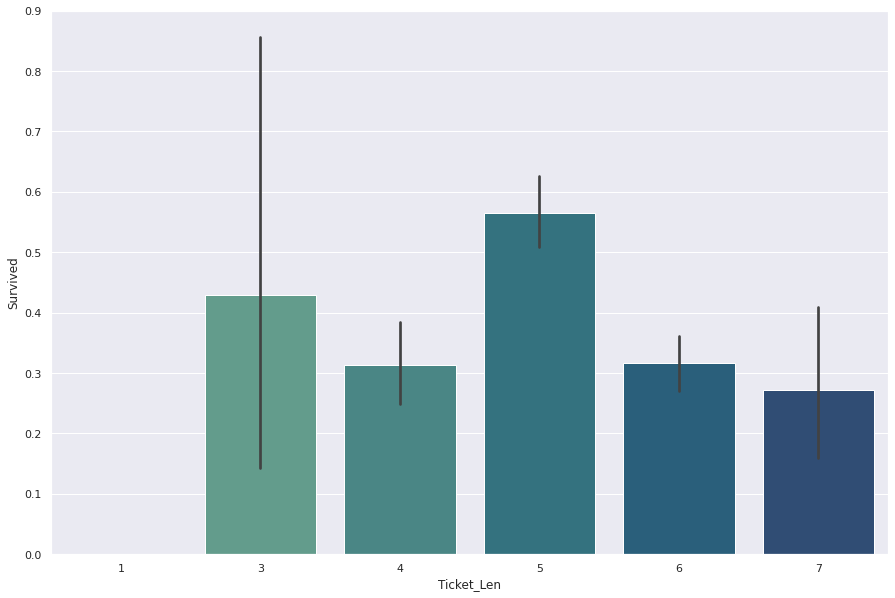

In [116]:
sns.barplot(data=train_df, x='Ticket_Len', y='Survived')

There doesn't seem to be a correlation between survival and char length of the ticket.

In [117]:
def ticket_first_digit(string):
    """Get the first digit of the ticket number"""
    nums = [str(num) for num in list(range(10))]
    num_only = ''
    for char in string.split()[-1]:
        if char in nums:
            return int(char)
    return 0 # We don't find a number

In [118]:
train_df['Ticket_First_Digit'] = train_df.apply(lambda row: ticket_first_digit(row['Ticket']), axis=1)

<AxesSubplot:xlabel='Ticket_First_Num', ylabel='Survived'>

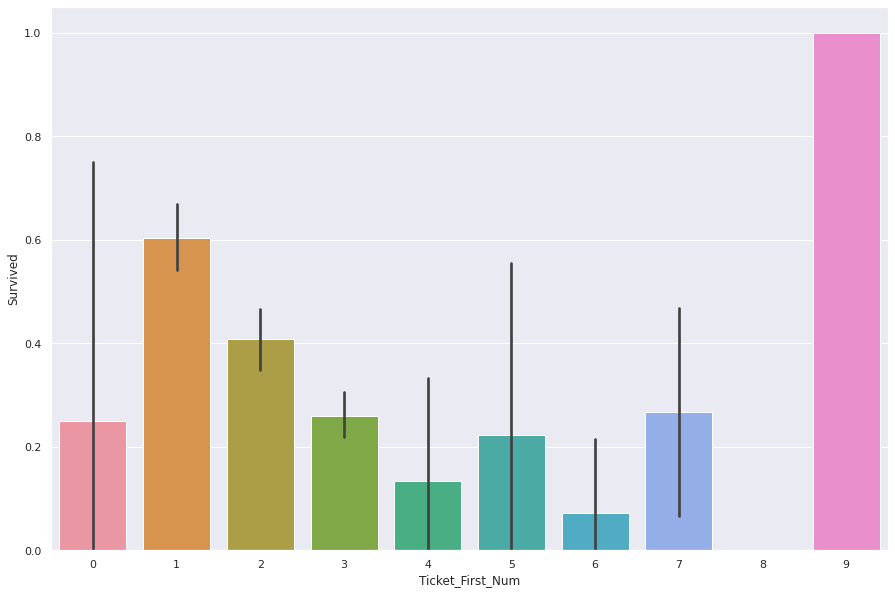

In [119]:
sns.barplot(data=train_df, x='Ticket_First_Digit', y='Survived')

Interestingly it seems that the first number of the ticket has some effect on the survival rate, although
the variances error is quite high.

#### Embarked

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

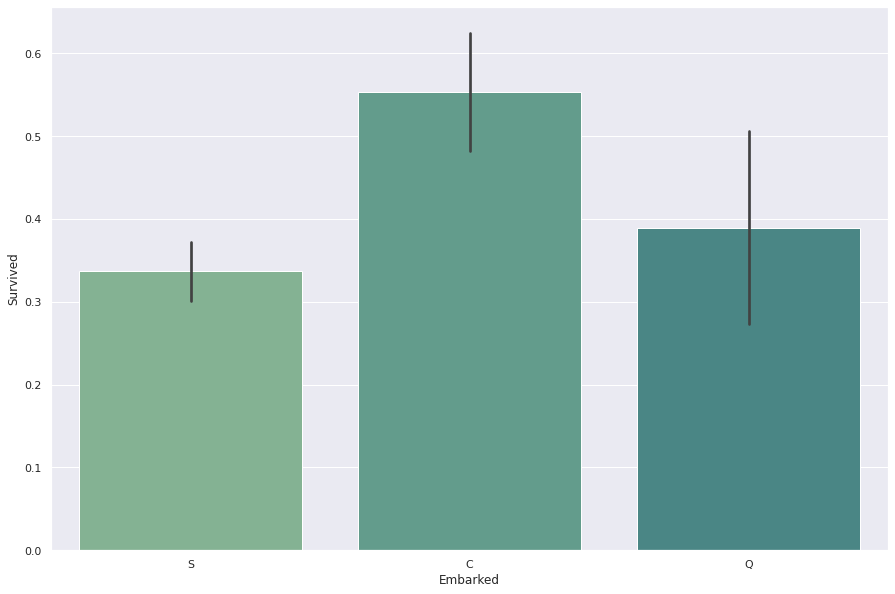

In [120]:
sns.barplot(data=train_df, x='Embarked', y='Survived')

It seems people who embarked from C are the most likely to survive.

## Feature Engineering

In [122]:
train_df.drop(['Name', 'Fare_Binned', 'Ticket', 'Ticket_Len'], inplace=True, axis=1)
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_Len,Ticket_Len,Ticket_First_Num
0,1,0,3,male,22.000000,1,0,7.2500,S,23,5,2
1,2,1,1,female,38.000000,1,0,71.2833,C,51,5,1
2,3,1,3,female,26.000000,0,0,7.9250,S,22,7,3
3,4,1,1,female,35.000000,1,0,53.1000,S,44,6,1
4,5,0,3,male,35.000000,0,0,8.0500,S,24,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.000000,0,0,13.0000,S,21,6,2
887,888,1,1,female,19.000000,0,0,30.0000,S,28,6,1
888,889,0,3,female,29.699118,1,2,23.4500,S,40,4,6
889,890,1,1,male,26.000000,0,0,30.0000,C,21,6,1


In the previous section we already created the Name_Len and Ticket_First_Num features. We now need to encode Sex and Embarked:

In [124]:
train_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [125]:
def sex_change(sex_str):
    """Returns 1 if female and 0 if male."""
    if sex_str == 'male':
        return 0
    else:
        return 1

In [126]:
# Binary encoding for the Sex feature
train_df['Sex'] = train_df.apply(lambda row: sex_change(row['Sex']), axis=1)

In [128]:
# Onehot encoding the Embarked feature
train_df = pd.get_dummies(train_df, columns=['Embarked'])

In [129]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Name_Len,Ticket_Len,Ticket_First_Num,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0,22.000000,1,0,7.2500,23,5,2,0,0,1
1,2,1,1,1,38.000000,1,0,71.2833,51,5,1,1,0,0
2,3,1,3,1,26.000000,0,0,7.9250,22,7,3,0,0,1
3,4,1,1,1,35.000000,1,0,53.1000,44,6,1,0,0,1
4,5,0,3,0,35.000000,0,0,8.0500,24,6,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,0,0,13.0000,21,6,2,0,0,1
887,888,1,1,1,19.000000,0,0,30.0000,28,6,1,0,0,1
888,889,0,3,1,29.699118,1,2,23.4500,40,4,6,0,0,1
889,890,1,1,0,26.000000,0,0,30.0000,21,6,1,1,0,0


In [131]:
train_df.dtypes

PassengerId           int64
Survived              int64
Pclass                int64
Sex                   int64
Age                 float64
SibSp                 int64
Parch                 int64
Fare                float64
Name_Len              int64
Ticket_Len            int64
Ticket_First_Num      int64
Embarked_C            uint8
Embarked_Q            uint8
Embarked_S            uint8
dtype: object

## Modelling